In [25]:
#HARMFUL BRAIN ACTIVITY CLASSIFICATION PROJECT 
''' Sponsor : Ali Ibrahim 

    Team Members :  Estuardo Melendez,  Manuel Jimenez ---- """"input names

'''

' Sponsor : Ali Ibrahim \n\n    Team Members :  Estuardo Melendez,  Manuel Jimenez ---- """"input names\n\n'

In [ ]:
#Pre-processing of Data :  Estuardo & Manny 

# Import necessary libraries for data handling, signal processing, and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt, spectrogram, iirnotch
from mne.preprocessing import ICA

#
## IF LIBRARIES ARE THROWING AN ERROR: 
## Open terminal and run: pip install 'name_of_library', e.g., pip install pandas 

# ATTENTION!!!!!! : Change the directory path to your dataset
#Manny C:/Users/Master/Documents/Project Data/hms-harmful-brain-activity-classification/train_eegs
#Estuardo /Users/estuardomelendez/Downloads/hms-harmful-brain-activity-classification/train_eegs
#Kevin "C:/Users/Kevin Tran/Documents/GitHub ED1/hms-harmful-brain-activity-classificationtrain_eegs/train_eegs"

# Directory containing the training EEG files (raw data)
train_eegs_dir = "C:/Users/Kevin Tran/Documents/GitHub ED1/hms-harmful-brain-activity-classificationtrain_eegs/train_eegs"


'''
hms-harmful-brain-activity-classification---- Data composition: 


train_eegs = Contains time-domain data
train_spectogram = Contains frequency-domain data
'''

# List all .parquet files in the specified directory
all_files = [os.path.join(train_eegs_dir, f) for f in os.listdir(train_eegs_dir) if f.endswith(".parquet")]

'''
## files_to_process can be changed to any integer between 1-100 for demo purposes or "ALL" for all files to be processed
   (processing all parquet files can take a long time)
'''
# Allows processing of either a subset of files ex (1-100) or all files in the directory
files_to_process = 2 # Change to "ALL" for processing all files

# which files to be processed 
if isinstance(files_to_process, int) and 1 <= files_to_process <= 100:
    files_to_process_list = all_files[:files_to_process]
elif files_to_process == "ALL":
    files_to_process_list = all_files
else:
    raise ValueError("files_to_process must be an integer between 1 and 100 or 'ALL'.")

# EEG Channel-to-Description Mapping: Maps channel names to their corresponding brain regions
channel_mapping = {
    "Fp1": "Frontal pole on the left hemisphere",
    "Fp2": "Frontal pole on the right hemisphere",
    "F3": "Frontal lobe on the left hemisphere",
    "F4": "Frontal lobe on the right hemisphere",
    "C3": "Central area on the left hemisphere",
    "C4": "Central area on the right hemisphere",
    "P3": "Parietal lobe on the left hemisphere",
    "P4": "Parietal lobe on the right hemisphere",
    "O1": "Occipital lobe on the left hemisphere",
    "O2": "Occipital lobe on the right hemisphere",
    "F7": "Anterior temporal lobe on the left hemisphere",
    "F8": "Anterior temporal lobe on the right hemisphere",
    "T3": "Mid-temporal lobe on the left hemisphere",
    "T4": "Mid-temporal lobe on the right hemisphere",
    "T5": "Posterior temporal lobe on the left hemisphere",
    "T6": "Posterior temporal lobe on the right hemisphere",
    "Fz": "Frontal midline",
    "Cz": "Central midline",
    "Pz": "Parietal midline"
}

# STEP 1: Notch filter function
def apply_notch_filter(signal, fs, freq=60.0, quality_factor=2.0):
    
    """
    Removes powerline noise at a specific frequency (default 60 Hz).
    Args:
        signal: The EEG signal (1D array).
        fs: Sampling frequency (Hz).
        freq: Frequency to remove (Hz, default = 60).
        quality_factor: Quality factor of the notch filter (default = 2.0).
    Returns:
        Filtered signal with the specified frequency removed.
    """

    b, a = iirnotch(w0=freq, Q=quality_factor, fs=fs)
    return filtfilt(b, a, signal)

# STEP 2: Bandpass Filter function
def apply_bandpass_filter(signal, fs, lowcut=0.5, highcut=40.0, order=5):
    
    """
    Retains signal components within a specific frequency range (default: 0.5–40 Hz).
    Args:
        signal: The EEG signal (1D array).
        fs: Sampling frequency (Hz).
        lowcut: Lower frequency bound (Hz, default = 0.5).
        highcut: Upper frequency bound (Hz, default = 40).
        order: Filter order (default = 5).
    Returns:
        Bandpass-filtered signal.
    """

    nyquist = 0.5 * fs # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# STEP 3: Artifact Removal with ICA (Optional)
def apply_ica(signal, fs, n_components=10):
    
    ica = ICA(n_components=n_components, random_state=42, max_iter='auto')
    signal_df = pd.DataFrame(signal)  # Convert signal to DataFrame for ICA compatibility
    ica.fit(signal_df)
    cleaned_signal = ica.apply(signal_df)
    return cleaned_signal.values  # Return cleaned signal as numpy array

# STEP 4: Normalize Signal
def normalize_signal(signal):
   
     return (signal - np.mean(signal)) / np.std(signal)

# STEP 5: Spectrogram Plot with Descriptions
def plot_spectrogram_with_description(signal, fs, channel_name, title_prefix="Spectrogram"):
    
    #Look up the description for the channel
    description = channel_mapping.get(channel_name, "Unknown channel")
    
    #Generate the spectrogram
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=128)
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Power (dB)')
    
    #Add a descriptive title
    plt.title(f"{title_prefix} ({channel_name} - {description})")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.ylim(0, 100)  # Limit to 100 Hz for EEG signals
    plt.show()

# function for Time-domain Plot
def plot_time_domain(signal, fs, channel_name, title_prefix="Signal in Time Domain"):
    
    # Look up the description for the channel
    description = channel_mapping.get(channel_name, "Unknown channel")
    
    time = np.arange(len(signal)) / fs
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal)
    plt.title(f"{title_prefix} ({channel_name} - {description})")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

# Preprocess and visualize a single File:
def process_single_file(file_path, fs=200):
    
    # Load data
    data = pd.read_parquet(file_path)
    print(f"Processing file: {file_path}")
    print(data.head())

    processed_data = {}
    for column in data.columns:
        raw_signal = data[column].values
        
        #Plot raw signal spectrogram
        plot_spectrogram_with_description(raw_signal, fs, channel_name=column, title_prefix="Raw Spectrogram")
        plot_time_domain(raw_signal, fs, channel_name=column, title_prefix="Raw Signal")
        
        #Apply notch filter and bandpass filter
        notch_filtered_signal = apply_notch_filter(raw_signal, fs, freq=60.0)
        bandpass_filtered_signal = apply_bandpass_filter(notch_filtered_signal, fs, lowcut=0.5, highcut=40.0)
        
        # Normalize the signal
        normalized_signal = normalize_signal(bandpass_filtered_signal)
        
        # (Optional) Apply ICA for artifact removal
        # cleaned_signal = apply_ica(normalized_signal, fs)  # Uncomment if ICA is needed
        
        #Plot processed signal spectrogram and time-domain signal
        plot_spectrogram_with_description(normalized_signal, fs, channel_name=column, title_prefix="Processed Spectrogram")
        plot_time_domain(normalized_signal, fs, channel_name=column, title_prefix="Processed Signal")
        
        # Store processed data
        processed_data[column] = normalized_signal

    # Convert processed data back to DataFrame
    processed_df = pd.DataFrame(processed_data)
    return processed_df

#Batch Process Files
def batch_process_files(file_list, output_dir=None, fs=200):
    
    for file_path in file_list:
        processed_df = process_single_file(file_path, fs=fs)
        
        # Optionally save the processed data
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            output_file = os.path.join(output_dir, os.path.basename(file_path))
            processed_df.to_parquet(output_file)
            print(f"Saved processed file to: {output_file}")

''' 
ATTENTION: CHANGE OUTPUT DIRECTORY F  output_dir  TO THE FILEPATH OF THE FOLDER WHERE YOU WANT TO SAVE THE PRE-PROCESSED EEGS!!!
'''
# Output Directory for Processed Files
#estuardo /Users/estuardomelendez/Desktop/processed_eegs
#manny /Users/Master/Documents/Project Data/processed_eegs
output_dir = "C:/Users/Kevin Tran/Documents/Project Data/processed_eegs"  # CHANGE TO YOUR OWN DIRECTORY 

# Run Batch Processing with Sampling Frequency of 200 --- Can be changed according to professors instructions:

batch_process_files(files_to_process_list, output_dir=output_dir, fs=200)



In [1]:
#FEATURE EXTRACTION: Estuardo & Manny 
'''
Preliminary implementation for feature extraction, We divided the parquet eeg file into 2 second intervals
and extracted time domain features such as :[mean, variance, skewness, kurtosis, rms, delta power, theta power ,alpha power, beta power & gamma]

Me & Manny are still waiting on our Sposors feedback, you will find a eeg_features file which I recommend you open with the RAINBOW CSV extension
for visual studio.

#Remember to change file paths to your own dataset directory and comment out the previos one

'''

import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import os

# CHANGE DIRECTORY TO YOU PROCESSED EEGS!!!!!
#Estuardo "/Users/estuardomelendez/Desktop/processed_eegs"
#Manny "C:/Users/Master/Documents/GitHub/ED1-PROJECT2024/processed_eegs" 
processed_eegs_dir = r"C:\Users\Kevin Tran\Documents\Project Data\processed_eegs"

processed_files = [os.path.join(processed_eegs_dir, f) for f in os.listdir(processed_eegs_dir) if f.endswith(".parquet")]


# Sampling frequency (Hz) and window size (in seconds)
fs = 200  # Sampling frequency (200 samples per second)
window_size_seconds = 2  # Duration of each window in seconds
window_size_samples = fs * window_size_seconds  # Convert window size to samples

#Function to split data into windows
def split_into_windows(signal, window_size):
    
    num_windows = len(signal) // window_size # Calculate number of complete windows
    windows = [signal[i * window_size:(i + 1) * window_size] for i in range(num_windows)]
    return windows

#Function to extract time-domain features
def extract_time_features(signal):
    
    features = {
        "mean": np.mean(signal),
        "variance": np.var(signal),
        "skewness": skew(signal),
        "kurtosis": kurtosis(signal),
        "rms": np.sqrt(np.mean(signal**2)),
        "zero_crossing_rate": np.sum(np.diff(np.sign(signal)) != 0) / len(signal)
    }
    return features

#function to extract frequency-domain features
def extract_frequency_features(signal, fs):
    
    freqs, psd = welch(signal, fs=fs, nperseg=256) #Compute PSD using Welch's method
    band_powers = {
        "delta_power": np.sum(psd[(freqs >= 0.5) & (freqs < 4)]),
        "theta_power": np.sum(psd[(freqs >= 4) & (freqs < 8)]),
        "alpha_power": np.sum(psd[(freqs >= 8) & (freqs < 13)]),
        "beta_power": np.sum(psd[(freqs >= 13) & (freqs < 30)]),
        "gamma_power": np.sum(psd[(freqs >= 30) & (freqs < 50)]),
        "spectral_entropy": -np.sum(psd * np.log(psd + 1e-10)) ## Avoid log(0) with small offset
    }
    return band_powers

#function to extract features from a single EEG file
def extract_features_from_file(file_path, fs, window_size_samples):
   
    # Load processed EEG data
    data = pd.read_parquet(file_path)
    
    # Extract features for each channel
    all_features = []
    for channel in data.columns:
        signal = data[channel].values
        
        # Split the signal into windows
        windows = split_into_windows(signal, window_size_samples)
        
        # Extract features from each window
        for i, window in enumerate(windows):
            time_features = extract_time_features(window)
            frequency_features = extract_frequency_features(window, fs)
            combined_features = {
                "file": os.path.basename(file_path),
                "channel": channel,
                "window": i,
                **time_features,
                **frequency_features
            }
            all_features.append(combined_features)
    
    # Return DataFrame with properly named columns
    return pd.DataFrame(all_features)

# Process all files and combine features by extracting features from all files in the directory
combined_features = []

for file_path in processed_files:
    print(f"Extracting features from: {file_path}")
    file_features = extract_features_from_file(file_path, fs, window_size_samples)
    combined_features.append(file_features)

# Combine features from all files into a single DataFrame
all_features_df = pd.concat(combined_features, ignore_index=True)

# Save extracted features to a CSV file for later use
#Estuardo "/Users/estuardomelendez/Desktop/eeg_features.csv"
#Manny /Users/Master/Documents/GitHub/ED1-PROJECT2024/eeg_features.csv
output_feature_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_features.csv"
all_features_df.to_csv(output_feature_file, index=False)

# Preview the extracted features
print(f"Features saved to: {output_feature_file}")
print("\nPreview of Extracted Features:")
print(all_features_df.head())





Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1000913311.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001369401.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001487592.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001717358.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002136740.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002142157.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002197945.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002379034.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002576868.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\proc

Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1000913311.parquet
Processing file: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1000913311.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001369401.parquet
Processing file: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001369401.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001487592.parquet
Processing file: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001487592.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001717358.parquet
Processing file: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1001717358.parquet
Extracting features from: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002136740.parquet
Processing file: C:\Users\Kevin Tran\Documents\Project Data\processed_eegs\1002136740.parquet
Extracting feat

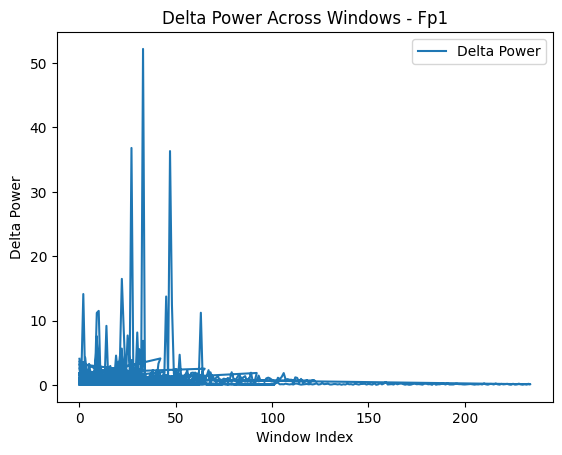

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import welch
import os
import matplotlib.pyplot as plt

# CHANGE DIRECTORY TO YOUR PROCESSED EEGS!!!
processed_eegs_dir = r"C:\Users\Kevin Tran\Documents\Project Data\processed_eegs"

# List all .parquet files in the specified directory
processed_files = [os.path.join(processed_eegs_dir, f) for f in os.listdir(processed_eegs_dir) if f.endswith(".parquet")]

# Sampling frequency (Hz) and window size (in seconds)
fs = 200  # Sampling frequency (200 samples per second)
window_size_seconds = 2  # Duration of each window in seconds
window_size_samples = fs * window_size_seconds  # Convert window size to samples


# Function to split data into fixed-size windows
def split_into_windows(signal, window_size):
    """
    Splits the input signal into fixed-size windows.
    Args:
        signal: The input EEG signal (1D array).
        window_size: Number of samples per window.
    Returns:
        A list of equally-sized signal windows.
    """
    num_windows = len(signal) // window_size  # Calculate the number of complete windows
    windows = [signal[i * window_size:(i + 1) * window_size] for i in range(num_windows)]  # Slice the signal
    return windows


# Function to extract time-domain features
def extract_time_features(signal):
    """
    Extracts statistical features from the signal in the time domain.
    Args:
        signal: The input EEG signal (1D array).
    Returns:
        A dictionary containing the computed features.
    """
    features = {
        "mean": np.mean(signal),  # Average value of the signal
        "variance": np.var(signal),  # Variability in the signal
        "skewness": skew(signal),  # Asymmetry of the signal
        "kurtosis": kurtosis(signal),  # "Peakedness" of the signal
        "rms": np.sqrt(np.mean(signal**2)),  # Root Mean Square of the signal
        "zero_crossing_rate": np.sum(np.diff(np.sign(signal)) != 0) / len(signal)  # Rate of zero crossings
    }
    return features


# Function to extract frequency-domain features
def extract_frequency_features(signal, fs):
    """
    Extracts frequency domain features from the signal using Welch's method.
    Args:
        signal: The input EEG signal (1D array).
        fs: Sampling frequency of the signal.
    Returns:
        A dictionary containing the computed frequency-domain features.
    """
    # Compute Power Spectral Density (PSD) using Welch's method
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    
    # Calculate band powers and spectral entropy
    band_powers = {
        "delta_power": np.sum(psd[(freqs >= 0.5) & (freqs < 4)]),  # Power in delta band (0.5–4 Hz)
        "theta_power": np.sum(psd[(freqs >= 4) & (freqs < 8)]),  # Power in theta band (4–8 Hz)
        "alpha_power": np.sum(psd[(freqs >= 8) & (freqs < 13)]),  # Power in alpha band (8–13 Hz)
        "beta_power": np.sum(psd[(freqs >= 13) & (freqs < 30)]),  # Power in beta band (13–30 Hz)
        "gamma_power": np.sum(psd[(freqs >= 30) & (freqs < 50)]),  # Power in gamma band (30–50 Hz)
        "spectral_entropy": -np.sum(psd * np.log(psd + 1e-10))  # Avoid log(0) with small offset
    }
    return band_powers


# Function to extract features from a single EEG file
def extract_features_from_file(file_path, fs, window_size_samples):
    """
    Processes an EEG file to extract both time-domain and frequency-domain features.
    Args:
        file_path: Path to the EEG file.
        fs: Sampling frequency of the signal.
        window_size_samples: Number of samples in each window.
    Returns:
        A DataFrame containing features for all channels and windows.
    """
    data = pd.read_parquet(file_path)  # Load EEG data
    print(f"Processing file: {file_path}")

    all_features = []  # List to store features for all windows and channels
    
    # Process each channel in the EEG data
    for channel in data.columns:
        signal = data[channel].values  # Get the signal for the current channel
        
        # Split the signal into windows
        windows = split_into_windows(signal, window_size_samples)
        
        # Extract features from each window
        for i, window in enumerate(windows):
            # Extract time-domain features
            time_features = extract_time_features(window)
            
            # Extract frequency-domain features
            frequency_features = extract_frequency_features(window, fs)
            
            # Combine features and add metadata
            combined_features = {
                "file": os.path.basename(file_path),  # File name
                "channel": channel,  # Channel name
                "window": i,  # Window index
                **time_features,  # Add time-domain features
                **frequency_features  # Add frequency-domain features
            }
            
            # Append to the list of all features
            all_features.append(combined_features)

    # Return the features as a DataFrame
    return pd.DataFrame(all_features)


# Process the first file to retrieve channel names
first_file_path = processed_files[0]
data = pd.read_parquet(first_file_path)
channels = data.columns.tolist()  # Get the list of channel names

# Process all files and combine features
combined_features = []

for file_path in processed_files:
    print(f"Extracting features from: {file_path}")
    file_features = extract_features_from_file(file_path, fs, window_size_samples)
    combined_features.append(file_features)

# Combine all features into a single DataFrame
all_features_df = pd.concat(combined_features, ignore_index=True)

# Save extracted features to a CSV file for later use
output_feature_file = r"C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_features.csv"
all_features_df.to_csv(output_feature_file, index=False)

# Preview the extracted features
print("\nExtracted Features:")
print(all_features_df.head())
print(f"Features saved to: {output_feature_file}")

# Visualize features for the first channel
first_channel_name = channels[0]  # Select the first channel
first_channel_features = all_features_df[all_features_df['channel'] == first_channel_name]

plt.plot(first_channel_features['window'], first_channel_features['delta_power'], label='Delta Power')
plt.title(f'Delta Power Across Windows - {first_channel_name}')
plt.xlabel('Window Index')
plt.ylabel('Delta Power')
plt.legend()
plt.show()


✅ Detailed anomalies saved to: C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_anomalies_detailed.csv
✅ EEG ID classifications saved to: C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_id_classifications.csv


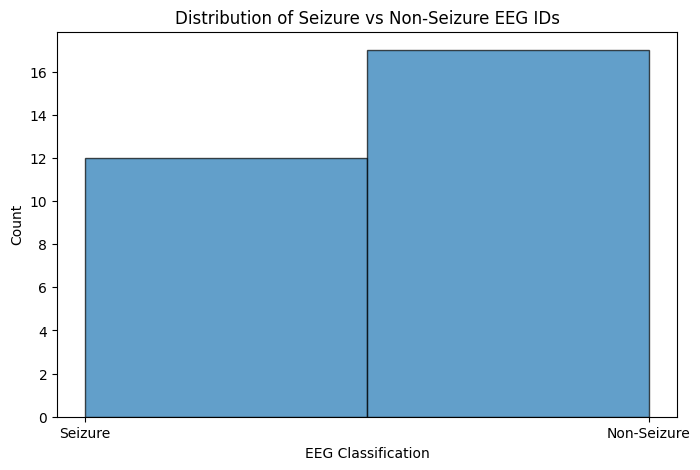

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 📌 Load the extracted EEG feature dataset
features_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_features.csv"
df_features = pd.read_csv(features_file)

# 📌 Extract EEG ID from the filename
df_features["eeg_id"] = df_features["file"].str.extract(r'(\d+)')  # Extract numeric EEG ID

# 📌 Drop Non-Numeric Columns Before Handling NaNs
numeric_columns = df_features.select_dtypes(include=[np.number]).columns
df_features[numeric_columns] = df_features[numeric_columns].fillna(df_features[numeric_columns].mean())  # Fill NaNs

# 📌 Drop non-numeric columns for Isolation Forest
X = df_features[numeric_columns].copy()

# 📌 Train the Isolation Forest Model
iso_forest = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
df_features["anomaly"] = iso_forest.fit_predict(X)  # -1 = Seizure-Like, 1 = Non-Seizure

# 📌 Save Detailed Anomalies for Each Channel
detailed_anomalies_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_anomalies_detailed.csv"
df_features.to_csv(detailed_anomalies_file, index=False)
print(f"✅ Detailed anomalies saved to: {detailed_anomalies_file}")

# 📌 Aggregate Anomalies by EEG ID
# If any channel in an EEG ID is classified as an anomaly (-1), the entire EEG ID is classified as Seizure
eeg_classifications = df_features.groupby("eeg_id")["anomaly"].apply(lambda x: -1 if (x == -1).any() else 1).reset_index()
eeg_classifications["classification"] = eeg_classifications["anomaly"].map({-1: "Seizure", 1: "Non-Seizure"})

# 📌 Save Results with EEG IDs
eeg_classifications_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_id_classifications.csv"
eeg_classifications.to_csv(eeg_classifications_file, index=False)
print(f"✅ EEG ID classifications saved to: {eeg_classifications_file}")

# 📊 Plot Distribution of EEG IDs (Seizure vs Non-Seizure)
plt.figure(figsize=(8, 5))
plt.hist(eeg_classifications["classification"], bins=2, edgecolor="black", alpha=0.7)
plt.xlabel("EEG Classification")
plt.ylabel("Count")
plt.title("Distribution of Seizure vs Non-Seizure EEG IDs")
plt.show()


✅ EEG ID classifications saved to: C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_id_classifications.csv


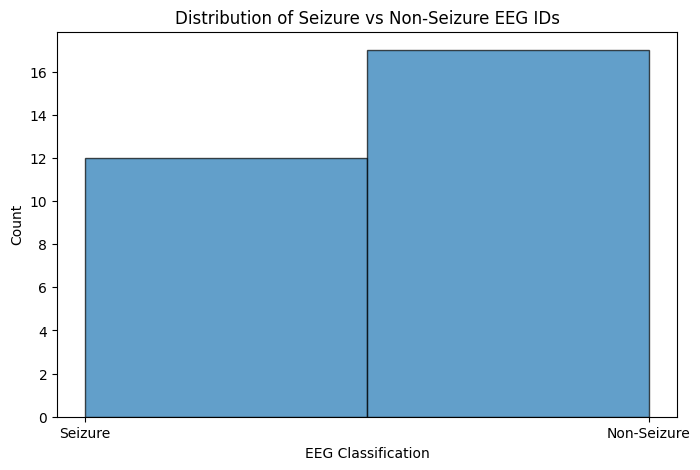

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 📌 Load the extracted EEG feature dataset
features_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_features.csv"
df_features = pd.read_csv(features_file)

# 📌 Extract EEG ID from the filename
df_features["eeg_id"] = df_features["file"].str.extract(r'(\d+)')  # Extract numeric EEG ID

# 📌 Drop Non-Numeric Columns Before Handling NaNs
numeric_columns = df_features.select_dtypes(include=[np.number]).columns
df_features[numeric_columns] = df_features[numeric_columns].fillna(df_features[numeric_columns].mean())  # Fill NaNs

# 📌 Drop non-numeric columns for Isolation Forest
X = df_features[numeric_columns].copy()

# 📌 Train the Isolation Forest Model
iso_forest = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
df_features["anomaly"] = iso_forest.fit_predict(X)  # -1 = Seizure-Like, 1 = Non-Seizure

# 📌 Aggregate Anomalies by EEG ID
# If any channel in an EEG ID is classified as an anomaly (-1), the entire EEG ID is classified as Seizure
eeg_classifications = df_features.groupby("eeg_id")["anomaly"].apply(lambda x: -1 if (x == -1).any() else 1).reset_index()
eeg_classifications["classification"] = eeg_classifications["anomaly"].map({-1: "Seizure", 1: "Non-Seizure"})

# 📌 Save Results with EEG IDs
output_file = "C:/Users/Kevin Tran/Documents/Project Data/feature extractions/eeg_id_classifications.csv"
eeg_classifications.to_csv(output_file, index=False)
print(f"✅ EEG ID classifications saved to: {output_file}")

# 📊 Plot Distribution of EEG IDs (Seizure vs Non-Seizure)
plt.figure(figsize=(8, 5))
plt.hist(eeg_classifications["classification"], bins=2, edgecolor="black", alpha=0.7)
plt.xlabel("EEG Classification")
plt.ylabel("Count")
plt.title("Distribution of Seizure vs Non-Seizure EEG IDs")
plt.show()
